## Fractal dimension


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [19]:
#!/usr/bin/env python3
# fractal_parallel_nz.py
# Requirements: numpy, pandas, scipy, tqdm
# Run: python fractal_parallel_nz.py

import numpy as np
import pandas as pd
from scipy import stats
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
import os
import math
import time

# ---------------- USER SETTINGS ----------------
CSV_FILE = "data.csv"        # your catalog
OUT_FILE = "D2_b_results_nz_large.csv"
MC = 3.0                    # set your completeness magnitude
WINDOW_SIZE = 100           # Hirata default
STEP = 10                   # Hirata default
N_R = 40                    # points for C(r)
BOOTSTRAP_REPS = 0          # set >0 for bootstrap per window (expensive)
NUM_WORKERS = max(1, cpu_count()-1)  # parallel workers
SAVE_EVERY = 2000           # checkpoint every this many windows
MAX_WINDOWS = None          # set to integer to limit processing (for testing)
# ------------------------------------------------

R_EARTH = 6371.0

def find_column(df, choices):
    for c in choices:
        if c in df.columns:
            return c
    return None

def great_circle_matrix(lat_deg, lon_deg):
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)
    cos_ang = np.cos(lat[:,None])*np.cos(lat[None,:]) + np.sin(lat[:,None])*np.sin(lat[None,:])*np.cos(lon[:,None]-lon[None,:])
    cos_ang = np.clip(cos_ang, -1.0, 1.0)
    ang = np.arccos(cos_ang)
    return R_EARTH * ang  # km

def correlation_integral_from_dists(dists, N, r_vals):
    denom = N*(N-1)
    return np.array([2.0 * np.sum(dists < r) / denom for r in r_vals])

def estimate_D2_from_positions(lat, lon, n_r=N_R):
    N = len(lat)
    if N < 3:
        return dict(D2=np.nan, D2_err=np.nan, r_min=np.nan, r_max=np.nan)

    Dmat = great_circle_matrix(lat, lon)
    iu = np.triu_indices(N, k=1)
    dists = Dmat[iu]
    dists_pos = dists[dists > 0]
    if dists_pos.size == 0:
        return dict(D2=np.nan, D2_err=np.nan, r_min=np.nan, r_max=np.nan)

    r_min = np.min(dists_pos) * 1.2
    r_max = np.max(dists_pos) / 2.0
    if r_min <= 0 or r_min >= r_max:
        r_min = np.min(dists_pos)
        r_max = np.max(dists_pos)

    r_vals = np.logspace(math.log10(r_min), math.log10(r_max), n_r)
    C = correlation_integral_from_dists(dists, N, r_vals)
    mask = C > 0
    if mask.sum() < 6:
        return dict(D2=np.nan, D2_err=np.nan, r_min=r_min, r_max=r_max)

    logr = np.log10(r_vals[mask])
    logC = np.log10(C[mask])

    w = max(6, int(0.12 * len(logr)))
    slopes, intercepts, rinds = [], [], []
    for i in range(len(logr)-w+1):
        x = logr[i:i+w]; y = logC[i:i+w]
        slope, intercept, r, p, se = stats.linregress(x,y)
        slopes.append(slope); intercepts.append(intercept)
        rinds.append((i, i+w-1))

    slopes = np.array(slopes)
    if slopes.size == 0:
        return dict(D2=np.nan, D2_err=np.nan, r_min=r_min, r_max=r_max)

    med = np.median(slopes)
    tol = 0.18 * max(1.0, abs(med))
    stable = np.abs(slopes - med) < tol

    best_len = 0; best_start = None; cur_len = 0; cur_start = 0
    for i, v in enumerate(stable):
        if v:
            if cur_len == 0: cur_start = i
            cur_len += 1
            if cur_len > best_len:
                best_len = cur_len; best_start = cur_start
        else:
            cur_len = 0

    if best_len > 0:
        sidx = rinds[best_start][0]; eidx = rinds[best_start+best_len-1][1]
        x = logr[sidx:eidx+1]; y = logC[sidx:eidx+1]
        slope, intercept, r, p, se = stats.linregress(x,y)
        D2, D2_err = slope, se
        fit_rmin, fit_rmax = 10**x[0], 10**x[-1]
    else:
        i0 = len(logr)//4; i1 = 3*len(logr)//4
        slope, intercept, r, p, se = stats.linregress(logr[i0:i1], logC[i0:i1])
        D2, D2_err = slope, se
        fit_rmin, fit_rmax = 10**logr[i0], 10**logr[i1-1]

    return dict(D2=D2, D2_err=D2_err, r_min=fit_rmin, r_max=fit_rmax)

def b_value_mle(mags, Mc):
    mags = np.asarray(mags)
    mags = mags[mags >= Mc]
    if mags.size == 0: return np.nan
    Mbar = mags.mean()
    if Mbar <= Mc: return np.nan
    return 0.4342944819 / (Mbar - Mc)

def process_window(idx_start, df, lat_col, lon_col, mag_col, win, Mc):
    subset = df.iloc[idx_start: idx_start+win]
    lat = subset[lat_col].values
    lon = subset[lon_col].values
    mags = subset[mag_col].values
    Dres = estimate_D2_from_positions(lat, lon, n_r=N_R)
    b = b_value_mle(mags, Mc)
    D_pred = 2.3 - 0.73*b if (not np.isnan(b)) else np.nan
    return {
        "start_idx": int(idx_start),
        "n_events": int(len(subset)),
        "D2": float(Dres["D2"]) if Dres["D2"] is not None else np.nan,
        "D2_err": float(Dres["D2_err"]) if Dres["D2_err"] is not None else np.nan,
        "r_min_km": float(Dres["r_min"]) if Dres["r_min"] is not None else np.nan,
        "r_max_km": float(Dres["r_max"]) if Dres["r_max"] is not None else np.nan,
        "b": float(b) if b is not None else np.nan,
        "D_pred": float(D_pred) if D_pred is not None else np.nan
    }

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def main():
    print("Reading CSV...")
    df = pd.read_csv(CSV_FILE)
    lat_col = find_column(df, ["latitude","lat","LAT","Latitude"])
    lon_col = find_column(df, ["longitude","lon","LON","Longitude","LONGITUDE"])
    mag_col = find_column(df, ["magnitude","mag","MAG","magnitude"])

    if lat_col is None or lon_col is None or mag_col is None:
        raise RuntimeError("CSV missing latitude/longitude/magnitude columns. Rename them appropriately.")

    depth_col = find_column(df, ["depth","DEPTH","depth_km"])
    if depth_col:
        df = df[df[depth_col] <= 60.0].reset_index(drop=True)

    time_col = find_column(df, ["time","date","datetime","origin_time"])
    if time_col:
        df = df.sort_values(time_col).reset_index(drop=True)

    df = df[df[mag_col] >= MC].reset_index(drop=True)
    n_total = len(df)
    print(f"Total events after Mc cut (Mc={MC}): {n_total}")

    win = WINDOW_SIZE if n_total >= WINDOW_SIZE else max(10, n_total//3)
    step = STEP if n_total >= WINDOW_SIZE else max(1, win//5)

    start_indices = list(range(0, n_total - win + 1, step))
    if MAX_WINDOWS:
        start_indices = start_indices[:MAX_WINDOWS]

    print(f"Window size {win}, step {step}, total windows {len(start_indices)}")
    results = []
    start_time = time.time()

    worker = partial(process_window, df=df, lat_col=lat_col, lon_col=lon_col, mag_col=mag_col, win=win, Mc=MC)

    batch_size = max(2000, NUM_WORKERS*20)
    all_batches = list(chunks(start_indices, batch_size))
    batch_idx = 0
    for batch in all_batches:
        batch_idx += 1
        print(f"Processing batch {batch_idx}/{len(all_batches)}  (batch size={len(batch)})")
        with Pool(processes=NUM_WORKERS) as pool:
            for res in tqdm(pool.imap_unordered(worker, batch), total=len(batch)):
                results.append(res)

        if len(results) >= SAVE_EVERY:
            tmp = pd.DataFrame(results)
            mode = 'a' if os.path.exists(OUT_FILE) else 'w'
            if mode == 'a':
                tmp.to_csv(OUT_FILE, mode=mode, header=False, index=False)
            else:
                tmp.to_csv(OUT_FILE, mode=mode, header=True, index=False)
            print(f"Checkpoint: saved {len(results)} rows to {OUT_FILE}")
            results = []

    if results:
        tmp = pd.DataFrame(results)
        if os.path.exists(OUT_FILE):
            tmp.to_csv(OUT_FILE, mode='a', header=False, index=False)
        else:
            tmp.to_csv(OUT_FILE, mode='w', header=True, index=False)
        print(f"Saved final chunk to {OUT_FILE}")

    elapsed = time.time() - start_time
    print("Done. Elapsed (s):", elapsed)

if __name__ == "__main__":
    main()


Reading CSV...
Total events after Mc cut (Mc=3.0): 75241
Window size 100, step 10, total windows 7515
Processing batch 1/4  (batch size=2000)


100%|██████████| 2000/2000 [01:24<00:00, 23.65it/s]


Checkpoint: saved 2000 rows to D2_b_results_nz_large.csv
Processing batch 2/4  (batch size=2000)


100%|██████████| 2000/2000 [01:23<00:00, 24.07it/s]

Checkpoint: saved 2000 rows to D2_b_results_nz_large.csv
Processing batch 3/4  (batch size=2000)



100%|██████████| 2000/2000 [01:22<00:00, 24.36it/s]

Checkpoint: saved 2000 rows to D2_b_results_nz_large.csv
Processing batch 4/4  (batch size=1515)



100%|██████████| 1515/1515 [01:02<00:00, 24.06it/s]

Saved final chunk to D2_b_results_nz_large.csv
Done. Elapsed (s): 313.2122218608856


## Save each chunk separately

In [5]:
#!/usr/bin/env python3
# fractal_parallel_nz.py
# Requirements: numpy, pandas, scipy, tqdm
# Run: python fractal_parallel_nz.py

import numpy as np
import pandas as pd
from scipy import stats
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
import os
import math
import time

# ---------------- USER SETTINGS ----------------
CSV_FILE = "data.csv"        # your catalog
OUT_FILE = "D2_b_results_nz_large.csv"
MC = 3.0                    # set your completeness magnitude
WINDOW_SIZE = 100           # Hirata default
STEP = 10                   # Hirata default
N_R = 40                    # points for C(r)
BOOTSTRAP_REPS = 0          # set >0 for bootstrap per window (expensive)
NUM_WORKERS = max(1, cpu_count()-1)  # parallel workers
SAVE_EVERY = 2000           # checkpoint every this many windows
MAX_WINDOWS = None          # set to integer to limit processing (for testing)
# ------------------------------------------------

R_EARTH = 6371.0

def find_column(df, choices):
    for c in choices:
        if c in df.columns:
            return c
    return None

def great_circle_matrix(lat_deg, lon_deg):
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)
    cos_ang = np.cos(lat[:,None])*np.cos(lat[None,:]) + np.sin(lat[:,None])*np.sin(lat[None,:])*np.cos(lon[:,None]-lon[None,:])
    cos_ang = np.clip(cos_ang, -1.0, 1.0)
    ang = np.arccos(cos_ang)
    return R_EARTH * ang  # km

def correlation_integral_from_dists(dists, N, r_vals):
    denom = N*(N-1)
    return np.array([2.0 * np.sum(dists < r) / denom for r in r_vals])

def estimate_D2_from_positions(lat, lon, n_r=N_R):
    N = len(lat)
    if N < 3:
        return dict(D2=np.nan, D2_err=np.nan, r_min=np.nan, r_max=np.nan)

    Dmat = great_circle_matrix(lat, lon)
    iu = np.triu_indices(N, k=1)
    dists = Dmat[iu]
    dists_pos = dists[dists > 0]
    if dists_pos.size == 0:
        return dict(D2=np.nan, D2_err=np.nan, r_min=np.nan, r_max=np.nan)

    r_min = np.min(dists_pos) * 1.2
    r_max = np.max(dists_pos) / 2.0
    if r_min <= 0 or r_min >= r_max:
        r_min = np.min(dists_pos)
        r_max = np.max(dists_pos)

    r_vals = np.logspace(math.log10(r_min), math.log10(r_max), n_r)
    C = correlation_integral_from_dists(dists, N, r_vals)
    mask = C > 0
    if mask.sum() < 6:
        return dict(D2=np.nan, D2_err=np.nan, r_min=r_min, r_max=r_max)

    logr = np.log10(r_vals[mask])
    logC = np.log10(C[mask])

    w = max(6, int(0.12 * len(logr)))
    slopes, intercepts, rinds = [], [], []
    for i in range(len(logr)-w+1):
        x = logr[i:i+w]; y = logC[i:i+w]
        slope, intercept, r, p, se = stats.linregress(x,y)
        slopes.append(slope); intercepts.append(intercept)
        rinds.append((i, i+w-1))

    slopes = np.array(slopes)
    if slopes.size == 0:
        return dict(D2=np.nan, D2_err=np.nan, r_min=r_min, r_max=r_max)

    med = np.median(slopes)
    tol = 0.18 * max(1.0, abs(med))
    stable = np.abs(slopes - med) < tol

    best_len = 0; best_start = None; cur_len = 0; cur_start = 0
    for i, v in enumerate(stable):
        if v:
            if cur_len == 0: cur_start = i
            cur_len += 1
            if cur_len > best_len:
                best_len = cur_len; best_start = cur_start
        else:
            cur_len = 0

    if best_len > 0:
        sidx = rinds[best_start][0]; eidx = rinds[best_start+best_len-1][1]
        x = logr[sidx:eidx+1]; y = logC[sidx:eidx+1]
        slope, intercept, r, p, se = stats.linregress(x,y)
        D2, D2_err = slope, se
        fit_rmin, fit_rmax = 10**x[0], 10**x[-1]
    else:
        i0 = len(logr)//4; i1 = 3*len(logr)//4
        slope, intercept, r, p, se = stats.linregress(logr[i0:i1], logC[i0:i1])
        D2, D2_err = slope, se
        fit_rmin, fit_rmax = 10**logr[i0], 10**logr[i1-1]

    return dict(D2=D2, D2_err=D2_err, r_min=fit_rmin, r_max=fit_rmax)

def b_value_mle(mags, Mc):
    mags = np.asarray(mags)
    mags = mags[mags >= Mc]
    if mags.size == 0: return np.nan
    Mbar = mags.mean()
    if Mbar <= Mc: return np.nan
    return 0.4342944819 / (Mbar - Mc)

def process_window(idx_start, df, lat_col, lon_col, mag_col, win, Mc):
    subset = df.iloc[idx_start: idx_start+win]
    lat = subset[lat_col].values
    lon = subset[lon_col].values
    mags = subset[mag_col].values
    Dres = estimate_D2_from_positions(lat, lon, n_r=N_R)
    b = b_value_mle(mags, Mc)
    D_pred = 2.3 - 0.73*b if (not np.isnan(b)) else np.nan
    return {
        "start_idx": int(idx_start),
        "n_events": int(len(subset)),
        "D2": float(Dres["D2"]) if Dres["D2"] is not None else np.nan,
        "D2_err": float(Dres["D2_err"]) if Dres["D2_err"] is not None else np.nan,
        "r_min_km": float(Dres["r_min"]) if Dres["r_min"] is not None else np.nan,
        "r_max_km": float(Dres["r_max"]) if Dres["r_max"] is not None else np.nan,
        "b": float(b) if b is not None else np.nan,
        "D_pred": float(D_pred) if D_pred is not None else np.nan
    }

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def main():
    print("Reading CSV...")
    df = pd.read_csv(CSV_FILE)
    lat_col = find_column(df, ["latitude","lat","LAT","Latitude"])
    lon_col = find_column(df, ["longitude","lon","LON","Longitude","LONGITUDE"])
    mag_col = find_column(df, ["magnitude","mag","MAG","magnitude"])

    if lat_col is None or lon_col is None or mag_col is None:
        raise RuntimeError("CSV missing latitude/longitude/magnitude columns. Rename them appropriately.")

    depth_col = find_column(df, ["depth","DEPTH","depth_km"])
    if depth_col:
        df = df[df[depth_col] <= 60.0].reset_index(drop=True)

    time_col = find_column(df, ["time","date","datetime","origin_time"])
    if time_col:
        df = df.sort_values(time_col).reset_index(drop=True)

    df = df[df[mag_col] >= MC].reset_index(drop=True)
    n_total = len(df)
    print(f"Total events after Mc cut (Mc={MC}): {n_total}")

    win = WINDOW_SIZE if n_total >= WINDOW_SIZE else max(10, n_total//3)
    step = STEP if n_total >= WINDOW_SIZE else max(1, win//5)

    start_indices = list(range(0, n_total - win + 1, step))
    if MAX_WINDOWS:
        start_indices = start_indices[:MAX_WINDOWS]

    print(f"Window size {win}, step {step}, total windows {len(start_indices)}")
    results = []
    start_time = time.time()

    worker = partial(process_window, df=df, lat_col=lat_col, lon_col=lon_col, mag_col=mag_col, win=win, Mc=MC)

    batch_size = max(2000, NUM_WORKERS*20)
    all_batches = list(chunks(start_indices, batch_size))
    batch_idx = 0
    for batch in all_batches:
        batch_idx += 1
        print(f"Processing batch {batch_idx}/{len(all_batches)}  (batch size={len(batch)})")
        with Pool(processes=NUM_WORKERS) as pool:
            for res in tqdm(pool.imap_unordered(worker, batch), total=len(batch)):
                results.append(res)

        if len(results) >= SAVE_EVERY:
            tmp = pd.DataFrame(results)
            mode = 'a' if os.path.exists(OUT_FILE) else 'w'
            if mode == 'a':
                tmp.to_csv(OUT_FILE, mode=mode, header=False, index=False)
            else:
                tmp.to_csv(OUT_FILE, mode=mode, header=True, index=False)
            print(f"Checkpoint: saved {len(results)} rows to {OUT_FILE}")
            results = []

    if results:
        tmp = pd.DataFrame(results)
        if os.path.exists(OUT_FILE):
            tmp.to_csv(OUT_FILE, mode='a', header=False, index=False)
        else:
            tmp.to_csv(OUT_FILE, mode='w', header=True, index=False)
        print(f"Saved final chunk to {OUT_FILE}")

    elapsed = time.time() - start_time
    print("Done. Elapsed (s):", elapsed)

if __name__ == "__main__":
    main()


Reading CSV...
Total events after Mc cut (Mc=3.0): 75241
Window size 100, step 10, total windows 7515
Processing batch 1/4  (batch size=2000)


 57%|█████▋    | 1142/2000 [00:48<00:36, 23.64it/s]Traceback (most recent call last):
  File "/usr/local/python/3.12.1/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/python/3.12.1/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/python/3.12.1/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_47861/34509124.py", line 129, in process_window
    Dres = estimate_D2_from_positions(lat, lon, n_r=N_R)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_47861/34509124.py", line 80, in estimate_D2_from_positions
    slope, intercept, r, p, se = stats.linregress(x,y)
                                 ^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py", line 579, in

KeyboardInterrupt: 

## Plot C(r) Vs r on log scale

In [30]:
data_frac = pd.read_csv("D2_b_results_nz_large.csv")
frac_data=data_frac.copy()
frac_data.head()


,start_idx,n_events,D2,D2_err,r_min_km,r_max_km,b,D_pred
0,0,100,1.114059,0.009382,0.994781,643.774633,0.757404,1.747095
1,10,100,1.083165,0.017630,3.818229,145.537358,0.772132,1.736343
2,20,100,0.955138,0.009593,2.819637,109.846021,0.777197,1.732646
3,30,100,0.928678,0.011852,1.527377,100.682336,0.757908,1.746727
4,40,100,0.988371,0.017173,30.981836,633.897370,0.767316,1.739860


In [31]:
frac_data.describe()

,start_idx,n_events,D2,D2_err,r_min_km,r_max_km,b,D_pred
count,7515.000000,7515.0,7515.000000,7.505000e+03,7515.000000,7515.000000,7515.000000,7515.000000
mean,37570.000000,100.0,1.247400,1.678241e-02,18.504052,340.969633,0.807494,1.710529
std,21695.379692,0.0,0.123349,9.759270e-03,15.815800,155.325563,0.078165,0.057060
min,0.000000,100.0,0.000000,1.644507e-16,0.000114,0.923587,0.581068,1.447386
25%,18785.000000,100.0,1.180144,1.131762e-02,9.107060,280.710188,0.752797,1.674110
50%,37570.000000,100.0,1.254960,1.450069e-02,14.199596,334.058878,0.802409,1.714241
75%,56355.000000,100.0,1.323720,1.955021e-02,22.557712,393.341664,0.857384,1.750458
max,75140.000000,100.0,1.644196,2.201493e-01,161.181046,1084.384048,1.167964,1.875820


Estimated fractal dimension D2 = 1.467 (slope of logC vs logr)
Fit stderr = 0.012, r^2 = 0.999


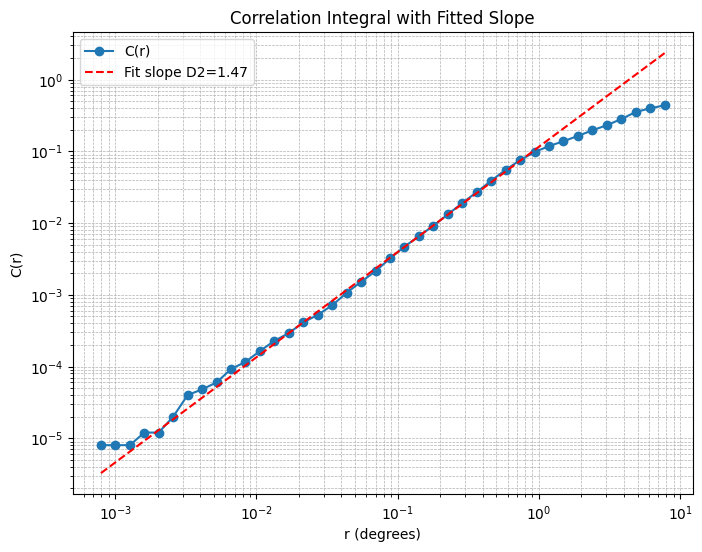

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. Angular distance function (degrees) ---
def angular_distance_matrix(lat_deg, lon_deg):
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)
    cos_ang = np.cos(lat[:,None]) * np.cos(lat[None,:]) + \
              np.sin(lat[:,None]) * np.sin(lat[None,:]) * np.cos(lon[:,None] - lon[None,:])
    cos_ang = np.clip(cos_ang, -1.0, 1.0)
    ang_rad = np.arccos(cos_ang)
    return np.degrees(ang_rad)

# --- 2. Load catalog ---
df = pd.read_csv("data.csv")
lat = df['latitude'].values[:500]    # subset of 100 events
lon = df['longitude'].values[:500]

# --- 3. Pairwise distances ---
D = angular_distance_matrix(lat, lon)
iu = np.triu_indices(len(lat), k=1)
dists = D[iu]

# --- 4. r values ---
dpos = dists[dists > 0]
r_min = np.min(dpos) * 1.2
r_max = np.max(dpos) / 2.0
r_vals = np.logspace(np.log10(r_min), np.log10(r_max), 40)

# --- 5. C(r) ---
N = len(lat)
C = np.array([np.sum(dists < r) / (N * (N - 1)) for r in r_vals])

# --- 6. Linear regression in scaling range ---
mask = C > 0
log_r = np.log10(r_vals[mask])
log_C = np.log10(C[mask])

# for simplicity, fit the middle 50% of the range
i0 = len(log_r)//4
i1 = 3*len(log_r)//4
slope, intercept, r_val, p_val, stderr = stats.linregress(log_r[i0:i1], log_C[i0:i1])
D2 = slope

print(f"Estimated fractal dimension D2 = {D2:.3f} (slope of logC vs logr)")
print(f"Fit stderr = {stderr:.3f}, r^2 = {r_val**2:.3f}")

# --- 7. Plot with fit line ---
plt.figure(figsize=(8,6))
plt.loglog(r_vals, C, 'o-', label="C(r)")
xs = np.logspace(np.log10(r_vals.min()), np.log10(r_vals.max()), 100)
plt.loglog(xs, 10**(intercept + slope*np.log10(xs)), 'r--',
           label=f"Fit slope D2={D2:.2f}")
plt.xlabel("r (degrees)")
plt.ylabel("C(r)")
plt.title("Correlation Integral with Fitted Slope")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.show()


In [15]:
pip install numpy pandas scipy matplotlib tqdm

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Gemini based

In [33]:
# SECTION 1: SETUP AND IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [34]:
# SECTION 2: DATA LOADING AND FILTERING

def load_and_filter_data(file_path, min_magnitude, max_depth):
    """
    Loads earthquake data from a CSV file and filters it.

    Args:
        file_path (str): The path to the CSV file.
        min_magnitude (float): The minimum magnitude to include.
        max_depth (float): The maximum depth to include.

    Returns:
        np.ndarray: A NumPy array of [latitude, longitude] for the filtered events,
                    or None if an error occurs.
    """
    column_names = ['date', 'time', 'latitude', 'longitude', 'depth', 'magnitude']
    try:
        df = pd.read_csv(
            file_path,
            header=None,
            delim_whitespace=True,
            names=column_names
        )
        print(f"✅ Successfully loaded {len(df)} total events from '{file_path}'.")

        # Apply filters
        df_filtered = df[(df['magnitude'] >= min_magnitude) & (df['depth'] <= max_depth)]
        print(f"➡️ Kept {len(df_filtered)} events after filtering (M >= {min_magnitude}, Depth <= {max_depth} km).")

        if df_filtered.empty:
            return None

        # Return just the latitude and longitude columns as a NumPy array
        return df_filtered[['latitude', 'longitude']].values

    except FileNotFoundError:
        print(f"❌ Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return None

#  Fractal Dimension Calculation

In [35]:
# SECTION 3, STEP 1: CALCULATE PAIRWISE DISTANCES

def calculate_pairwise_distances(coords):
    """
    Calculates the pairwise angular distances between all points.

    Args:
        coords (np.ndarray): Array of [lat, lon] coordinates.

    Returns:
        np.ndarray: A 1D array of distances between unique pairs.
    """
    n_points = len(coords)
    if n_points < 2:
        return np.array([])

    # Convert degrees to radians
    points_rad = np.deg2rad(coords)
    lat_rad = points_rad[:, 0]
    lon_rad = points_rad[:, 1]

    # Vectorized Haversine formula for angular distance
    dlon = lon_rad[:, np.newaxis] - lon_rad
    a = np.sin((lat_rad[:, np.newaxis] - lat_rad) / 2)**2 + \
        np.cos(lat_rad)[:, np.newaxis] * np.cos(lat_rad) * np.sin(dlon / 2)**2
    angular_distances_matrix = 2 * np.arcsin(np.sqrt(a))

    # Get the upper triangle of the distance matrix to avoid duplicates
    indices = np.triu_indices(n_points, k=1)
    return angular_distances_matrix[indices]

In [36]:
# SECTION 3, STEP 2: COMPUTE THE CORRELATION INTEGRAL

def compute_correlation_integral(distances, n_points):
    """
    Computes the correlation integral C(r) for a range of distances r.

    Args:
        distances (np.ndarray): 1D array of pairwise distances.
        n_points (int): The total number of data points.

    Returns:
        tuple: A tuple containing (r_values, c_r_values).
    """
    # Create logarithmically spaced distance bins (r values)
    min_dist = np.min(distances[distances > 0])
    max_dist = np.max(distances)
    r_values = np.logspace(np.log10(min_dist), np.log10(max_dist), 50)

    # Count pairs within each r
    c_r_values = np.array([np.sum(distances < r) for r in r_values])

    # Normalize by the total number of pairs
    total_pairs = n_points * (n_points - 1) / 2
    c_r_values = c_r_values / total_pairs

    # Remove points where C(r) is 0 to avoid log(0) errors
    valid_indices = c_r_values > 0
    return r_values[valid_indices], c_r_values[valid_indices]

In [37]:
# SECTION 3, STEP 3: PERFORM REGRESSION TO FIND D2

def fit_fractal_dimension(r_values, c_r_values, fit_start_ratio=0.25, fit_end_ratio=0.75):
    """
    Fits a line to the log-log plot to find the fractal dimension.

    Args:
        r_values (np.ndarray): Array of r values.
        c_r_values (np.ndarray): Array of C(r) values.
        fit_start_ratio (float): The starting percentile of points to use for the fit.
        fit_end_ratio (float): The ending percentile of points to use for the fit.

    Returns:
        dict: A dictionary containing the slope (D2), intercept, and r_squared.
    """
    log_r = np.log(r_values)
    log_c_r = np.log(c_r_values)

    # Select the linear portion of the curve for fitting
    fit_start_idx = int(len(log_r) * fit_start_ratio)
    fit_end_idx = int(len(log_r) * fit_end_ratio)

    if fit_end_idx - fit_start_idx < 2:
        return {'slope': np.nan, 'intercept': np.nan, 'r_squared': np.nan}

    slope, intercept, r_val, _, _ = linregress(
        log_r[fit_start_idx:fit_end_idx],
        log_c_r[fit_start_idx:fit_end_idx]
    )

    return {
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_val**2,
        'fit_indices': (fit_start_idx, fit_end_idx)
    }

In [38]:
# SECTION 4: VISUALIZATION

def plot_results(r_values, c_r_values, fit_params):
    """
    Generates and displays the final log-log plot.
    """
    slope = fit_params['slope']
    intercept = fit_params['intercept']
    start_idx, end_idx = fit_params['fit_indices']

    plt.figure(figsize=(10, 6))
    plt.loglog(r_values, c_r_values, 'o', markersize=5, label='Data points')
    plt.loglog(r_values[start_idx:end_idx], c_r_values[start_idx:end_idx], 'o', color='red', label='Points used for fitting')

    # Create the fitted line data
    fit_line = np.exp(intercept) * r_values**slope
    plt.loglog(r_values, fit_line, 'k-', label=f'Fit line (D2 = {slope:.2f})')

    plt.title('Log-Log Plot of Correlation Integral C(r) vs. Distance r')
    plt.xlabel('Distance r (radians)')
    plt.ylabel('Correlation Integral C(r)')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

In [ ]:
# SECTION 5: MAIN EXECUTION BLOCK

if __name__ == "__main__":
    # --- Parameters to set ---
    FILE_PATH = 'data.csv'
    MIN_MAGNITUDE = 3.0 # Adjust based on your catalog's completeness
    MAX_DEPTH = 60.0    # Adjust based on your study area

    # --- Run the analysis pipeline ---
    coords = load_and_filter_data(FILE_PATH, MIN_MAGNITUDE, MAX_DEPTH)

    if coords is not None and len(coords) > 10:
        distances = calculate_pairwise_distances(coords)
        r, c_r = compute_correlation_integral(distances, len(coords))
        
        # You may need to adjust the fit ratios after inspecting the plot
        fit_parameters = fit_fractal_dimension(r, c_r, fit_start_ratio=0.2, fit_end_ratio=0.8)

        print(f"📈 Fractal Dimension (D2): {fit_parameters['slope']:.3f}")
        print(f"   Fit Quality (R^2): {fit_parameters['r_squared']:.3f}")

        plot_results(r, c_r, fit_parameters)
    else:
        print("Analysis stopped due to lack of sufficient data after filtering.")
        

/tmp/ipykernel_2985/1825678825.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


✅ Successfully loaded 396272 total events from 'data.csv'.
➡️ Kept 0 events after filtering (M >= 3.0, Depth <= 60.0 km).
Analysis stopped due to lack of sufficient data after filtering.


✅ Successfully loaded 396271 total events from 'data.csv'.
➡️ Kept 120 events after filtering (M >= 5.9, Depth <= 200 km).

--- Results ---
📈 Fractal Dimension (D2): 1.342
   Fit Quality (R^2): 0.991
💾 Results saved to 'fractal_dimension_results.csv'
📊 Plot saved to 'fractal_dimension_plot.png'


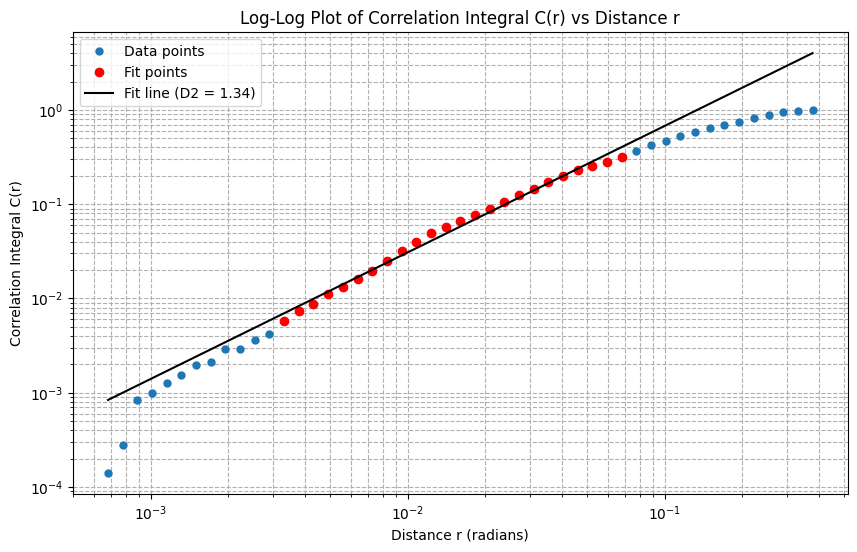

In [11]:
# ===========================================================
# FRACTAL DIMENSION CALCULATION FOR EARTHQUAKE DATA
# ===========================================================

# ------------------ SECTION 1: IMPORTS --------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ===========================================================

# ------------------ SECTION 2: DATA LOADING ----------------
def load_and_filter_data(file_path, min_magnitude, max_depth):
    """
    Loads earthquake data from a CSV file and filters it.
    Returns latitude and longitude coordinates.
    """
    column_names = ['date', 'time', 'latitude', 'longitude', 'depth', 'magnitude']
    try:
        df = pd.read_csv(file_path )
        print(f"✅ Successfully loaded {len(df)} total events from '{file_path}'.")
        df_filtered = df[(df['magnitude'] >= min_magnitude) & (df['depth'] <= max_depth)]
        print(f"➡️ Kept {len(df_filtered)} events after filtering (M >= {min_magnitude}, Depth <= {max_depth} km).")
        return df_filtered[['latitude', 'longitude', 'magnitude']].values if not df_filtered.empty else None
    except FileNotFoundError:
        print(f"❌ Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return None

# ===========================================================

# ------------------ SECTION 3: FRACTAL DIMENSION -----------

# Step 3.1: Calculate pairwise angular distances (in radians)
def calculate_pairwise_distances(coords):
    n_points = len(coords)
    if n_points < 2: return np.array([])
    
    lat_rad = np.deg2rad(coords[:, 0])
    lon_rad = np.deg2rad(coords[:, 1])
    
    dlat = lat_rad[:, np.newaxis] - lat_rad
    dlon = lon_rad[:, np.newaxis] - lon_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat_rad)[:, np.newaxis] * np.cos(lat_rad) * np.sin(dlon / 2)**2
    angular_distances_matrix = 2 * np.arcsin(np.sqrt(a))
    
    iu = np.triu_indices(n_points, k=1)
    return angular_distances_matrix[iu]

# Step 3.2: Compute correlation integral C(r)
def compute_correlation_integral(distances, n_points):
    if len(distances) == 0:
        return np.array([]), np.array([])
    
    positive_distances = distances[distances > 0]
    if len(positive_distances) == 0:
        positive_distances = distances
    
    min_dist = np.min(positive_distances)
    max_dist = np.max(distances)
    
    r_values = np.logspace(np.log10(min_dist), np.log10(max_dist), 50)
    c_r_values = np.array([np.sum(distances < r) for r in r_values])
    total_pairs = n_points * (n_points - 1) / 2
    c_r_values = c_r_values / total_pairs
    
    valid_indices = c_r_values > 0
    return r_values[valid_indices], c_r_values[valid_indices]

# Step 3.3: Fit fractal dimension D2 via linear regression in log-log space
def fit_fractal_dimension(r_values, c_r_values, fit_start_ratio=0.25, fit_end_ratio=0.75):
    log_r, log_c_r = np.log(r_values), np.log(c_r_values)
    fit_start_idx, fit_end_idx = int(len(log_r) * fit_start_ratio), int(len(log_r) * fit_end_ratio)
    if fit_end_idx - fit_start_idx < 2:
        return {'slope': np.nan, 'intercept': np.nan, 'r_squared': np.nan, 'fit_indices': (fit_start_idx, fit_end_idx)}
    
    slope, intercept, r_val, _, _ = linregress(log_r[fit_start_idx:fit_end_idx], log_c_r[fit_start_idx:fit_end_idx])
    return {'slope': slope, 'intercept': intercept, 'r_squared': r_val**2, 'fit_indices': (fit_start_idx, fit_end_idx)}

# ===========================================================

# ------------------ SECTION 4: SAVE RESULTS ----------------
def save_results_to_csv(filename, r_values, c_r_values, fit_params):
    df = pd.DataFrame({
        'r_distance_radians': r_values,
        'correlation_integral_c_r': c_r_values,
        'fractal_dimension_D2': fit_params['slope'],
        'fit_r_squared': fit_params['r_squared']
    })
    try:
        df.to_csv(filename, index=False)
        print(f"💾 Results saved to '{filename}'")
    except Exception as e:
        print(f"❌ Could not save CSV: {e}")

# ===========================================================

# ------------------ SECTION 5: PLOT RESULTS ----------------
def plot_and_show_results(filename, r_values, c_r_values, fit_params):
    slope, intercept = fit_params['slope'], fit_params['intercept']
    start_idx, end_idx = fit_params['fit_indices']

    plt.figure(figsize=(10, 6))
    plt.loglog(r_values, c_r_values, 'o', markersize=5, label='Data points')
    plt.loglog(r_values[start_idx:end_idx], c_r_values[start_idx:end_idx], 'o', color='red', label='Fit points')
    
    fit_line = np.exp(intercept) * r_values**slope
    plt.loglog(r_values, fit_line, 'k-', label=f'Fit line (D2 = {slope:.2f})')
    
    plt.title('Log-Log Plot of Correlation Integral C(r) vs Distance r')
    plt.xlabel('Distance r (radians)')
    plt.ylabel('Correlation Integral C(r)')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    
    try:
        plt.savefig(filename, dpi=300)
        print(f"📊 Plot saved to '{filename}'")
    except Exception as e:
        print(f"❌ Could not save plot: {e}")
    
    plt.show()
    plt.close()

# ===========================================================

# ------------------ SECTION 6: MAIN EXECUTION -------------
if __name__ == "__main__":
    # Parameters
    INPUT_FILE = 'data.csv'                       # Input earthquake data
    RESULTS_FILE = 'fractal_dimension_results.csv'
    PLOT_FILE = 'fractal_dimension_plot.png'
    
    MIN_MAGNITUDE = 5.9
    MAX_DEPTH = 200
    
    # Load and filter data
    coords_mag = load_and_filter_data(INPUT_FILE, MIN_MAGNITUDE, MAX_DEPTH)
    
    if coords_mag is not None and len(coords_mag) > 10:
        coords = coords_mag[:, :2]  # Only lat/lon for distance calculation
        magnitudes = coords_mag[:, 2]
        
        # Calculate distances, correlation integral, and D2
        distances = calculate_pairwise_distances(coords)
        r, c_r = compute_correlation_integral(distances, len(coords))
        fit_params = fit_fractal_dimension(r, c_r)
        
        # Show results
        print(f"\n--- Results ---")
        print(f"📈 Fractal Dimension (D2): {fit_params['slope']:.3f}")
        print(f"   Fit Quality (R^2): {fit_params['r_squared']:.3f}")
        
        # Save CSV and plot
        save_results_to_csv(RESULTS_FILE, r, c_r, fit_params)
        plot_and_show_results(PLOT_FILE, r, c_r, fit_params)
        
    else:
        print("\n⚠️ Not enough data after filtering. Analysis stopped.")


✅ Successfully loaded 396271 total events from 'data.csv'.
➡️ Kept 75241 events after filtering (M >= 3, Depth <= 60.0 km).
⚠️ Dataset too large (75241 points), downsampling to 10000 points for memory efficiency.

--- Results ---
📈 Fractal Dimension (D2): 1.169
   Fit Quality (R^2): 0.918
💾 Results saved to 'fractal_dimension_results.csv'
📊 Plot saved to 'fractal_dimension_plot.png'


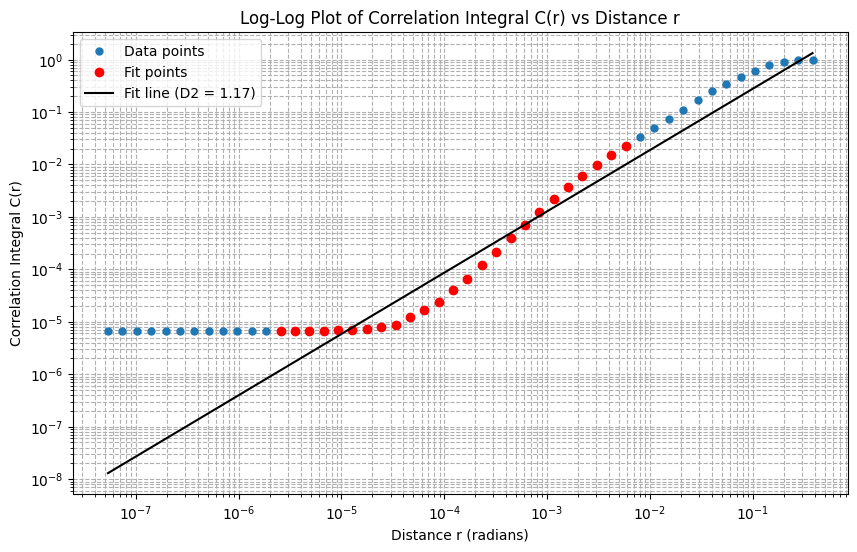

In [1]:
# ===========================================================
# FRACTAL DIMENSION CALCULATION FOR EARTHQUAKE DATA
# MEMORY-EFFICIENT VERSION
# ===========================================================

# ------------------ SECTION 1: IMPORTS --------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.spatial.distance import pdist

# ===========================================================

# ------------------ SECTION 2: DATA LOADING ----------------
def load_and_filter_data(file_path, min_magnitude, max_depth):
    """
    Loads earthquake data from a CSV file and filters it.
    Returns latitude, longitude, and magnitude.
    """
    column_names = ['date', 'time', 'latitude', 'longitude', 'depth', 'magnitude']
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded {len(df)} total events from '{file_path}'.")
        df_filtered = df[(df['magnitude'] >= min_magnitude) & (df['depth'] <= max_depth)]
        print(f"➡️ Kept {len(df_filtered)} events after filtering (M >= {min_magnitude}, Depth <= {max_depth} km).")
        if df_filtered.empty:
            return None
        return df_filtered[['latitude', 'longitude', 'magnitude']].values
    except FileNotFoundError:
        print(f"❌ Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return None

# ===========================================================

# ------------------ SECTION 3: FRACTAL DIMENSION -----------

def calculate_pairwise_distances(coords):
    """
    Memory-efficient pairwise angular distances using haversine formula and pdist.
    Returns 1D array of all unique pairwise distances (radians).
    """
    if len(coords) < 2:
        return np.array([])

    # Convert degrees to radians
    coords_rad = np.deg2rad(coords)

    # Haversine distance function
    def haversine(u, v):
        lat1, lon1 = u
        lat2, lon2 = v
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        return 2 * np.arcsin(np.sqrt(a))

    distances = pdist(coords_rad, metric=haversine)
    return distances

def compute_correlation_integral(distances, n_points):
    """
    Compute correlation integral C(r) for a range of distances r.
    """
    if len(distances) == 0:
        return np.array([]), np.array([])

    positive_distances = distances[distances > 0]
    if len(positive_distances) == 0:
        positive_distances = distances

    min_dist = np.min(positive_distances)
    max_dist = np.max(distances)

    r_values = np.logspace(np.log10(min_dist), np.log10(max_dist), 50)
    c_r_values = np.array([np.sum(distances < r) for r in r_values])
    total_pairs = n_points * (n_points - 1) / 2
    c_r_values = c_r_values / total_pairs

    valid_indices = c_r_values > 0
    return r_values[valid_indices], c_r_values[valid_indices]

def fit_fractal_dimension(r_values, c_r_values, fit_start_ratio=0.25, fit_end_ratio=0.75):
    """
    Fit D2 using linear regression on log-log C(r) vs r.
    """
    log_r, log_c_r = np.log(r_values), np.log(c_r_values)
    fit_start_idx, fit_end_idx = int(len(log_r) * fit_start_ratio), int(len(log_r) * fit_end_ratio)
    if fit_end_idx - fit_start_idx < 2:
        return {'slope': np.nan, 'intercept': np.nan, 'r_squared': np.nan, 'fit_indices': (fit_start_idx, fit_end_idx)}

    slope, intercept, r_val, _, _ = linregress(log_r[fit_start_idx:fit_end_idx], log_c_r[fit_start_idx:fit_end_idx])
    return {'slope': slope, 'intercept': intercept, 'r_squared': r_val**2, 'fit_indices': (fit_start_idx, fit_end_idx)}

# ===========================================================

# ------------------ SECTION 4: SAVE RESULTS ----------------
def save_results_to_csv(filename, r_values, c_r_values, fit_params):
    df = pd.DataFrame({
        'r_distance_radians': r_values,
        'correlation_integral_c_r': c_r_values,
        'fractal_dimension_D2': fit_params['slope'],
        'fit_r_squared': fit_params['r_squared']
    })
    try:
        df.to_csv(filename, index=False)
        print(f"💾 Results saved to '{filename}'")
    except Exception as e:
        print(f"❌ Could not save CSV: {e}")

# ===========================================================

# ------------------ SECTION 5: PLOT RESULTS ----------------
def plot_and_show_results(filename, r_values, c_r_values, fit_params):
    slope, intercept = fit_params['slope'], fit_params['intercept']
    start_idx, end_idx = fit_params['fit_indices']

    plt.figure(figsize=(10, 6))
    plt.loglog(r_values, c_r_values, 'o', markersize=5, label='Data points')
    plt.loglog(r_values[start_idx:end_idx], c_r_values[start_idx:end_idx], 'o', color='red', label='Fit points')

    fit_line = np.exp(intercept) * r_values**slope
    plt.loglog(r_values, fit_line, 'k-', label=f'Fit line (D2 = {slope:.2f})')

    plt.title('Log-Log Plot of Correlation Integral C(r) vs Distance r')
    plt.xlabel('Distance r (radians)')
    plt.ylabel('Correlation Integral C(r)')
    plt.grid(True, which="both", ls="--")
    plt.legend()

    try:
        plt.savefig(filename, dpi=300)
        print(f"📊 Plot saved to '{filename}'")
    except Exception as e:
        print(f"❌ Could not save plot: {e}")

    plt.show()
    plt.close()

# ===========================================================

# ------------------ SECTION 6: MAIN EXECUTION -------------
if __name__ == "__main__":
    # ---------------- PARAMETERS ----------------
    INPUT_FILE = 'data.csv'
    RESULTS_FILE = 'fractal_dimension_results.csv'
    PLOT_FILE = 'fractal_dimension_plot.png'

    MIN_MAGNITUDE = 3
    MAX_DEPTH = 60.0
    MAX_POINTS = 10000  # Downsample to avoid memory issues

    # ---------------- LOAD DATA ----------------
    coords_mag = load_and_filter_data(INPUT_FILE, MIN_MAGNITUDE, MAX_DEPTH)

    if coords_mag is not None and len(coords_mag) > 10:
        # Optional downsampling for large datasets
        if len(coords_mag) > MAX_POINTS:
            print(f"⚠️ Dataset too large ({len(coords_mag)} points), downsampling to {MAX_POINTS} points for memory efficiency.")
            indices = np.random.choice(len(coords_mag), size=MAX_POINTS, replace=False)
            coords_mag = coords_mag[indices]

        coords = coords_mag[:, :2]  # lat/lon for distances
        magnitudes = coords_mag[:, 2]

        # ---------------- FRACTAL ANALYSIS ----------------
        distances = calculate_pairwise_distances(coords)
        r, c_r = compute_correlation_integral(distances, len(coords))
        fit_params = fit_fractal_dimension(r, c_r)

        # ---------------- RESULTS ----------------
        print(f"\n--- Results ---")
        print(f"📈 Fractal Dimension (D2): {fit_params['slope']:.3f}")
        print(f"   Fit Quality (R^2): {fit_params['r_squared']:.3f}")

        save_results_to_csv(RESULTS_FILE, r, c_r, fit_params)
        plot_and_show_results(PLOT_FILE, r, c_r, fit_params)

    else:
        print("\n⚠️ Not enough data after filtering. Analysis stopped.")


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd

def calculate_fractal_dimension(data):
    """
    Calculates the correlation dimension (D2) for a set of epicenter data.
    (This function is the same as before)
    """
    # --- 1. Data Preparation ---
    points_rad = np.deg2rad(data)
    lat_rad = points_rad[:, 0]
    lon_rad = points_rad[:, 1]
    
    n_points = len(points_rad)
    if n_points < 10: # Increased minimum points for a more stable fit
        print("Not enough points to calculate a reliable fractal dimension.")
        return

    # --- 2. Calculate Pairwise Distances ---
    dlon = lon_rad[:, np.newaxis] - lon_rad
    dlat = lat_rad[:, np.newaxis] - lat_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat_rad)[:, np.newaxis] * np.cos(lat_rad) * np.sin(dlon / 2)**2
    angular_distances = 2 * np.arcsin(np.sqrt(a))
    
    indices = np.triu_indices(n_points, k=1)
    distances = angular_distances[indices]
    
    # --- 3. Compute Correlation Integral C(r) ---
    min_dist = np.min(distances[distances > 0])
    max_dist = np.max(distances)
    r_values = np.logspace(np.log10(min_dist), np.log10(max_dist), 50)
    
    c_r = [np.sum(distances < r) for r in r_values]
    total_pairs = n_points * (n_points - 1) / 2
    c_r = np.array(c_r) / total_pairs

    valid_indices = c_r > 0
    if not np.any(valid_indices):
        print("Could not compute correlation integral for any r.")
        return
        
    r_values = r_values[valid_indices]
    c_r = c_r[valid_indices]
    
    # --- 4. Perform Linear Regression on the Log-Log Plot ---
    log_r = np.log(r_values)
    log_c_r = np.log(c_r)
    
    # Adjust this fitting range after inspecting your plot
    fit_start = int(len(log_r) * 0.25)
    fit_end = int(len(log_r) * 0.75)
    
    if fit_end - fit_start < 2:
        print("Could not find a suitable linear region to fit.")
        slope, intercept, r_value_linreg = np.nan, np.nan, np.nan
    else:
        slope, intercept, r_value_linreg, _, _ = linregress(log_r[fit_start:fit_end], log_c_r[fit_start:fit_end])
    
    fractal_dimension = slope
    print(f"📈 Calculated Fractal Dimension (D2): {fractal_dimension:.3f}")
    print(f"   Correlation Coefficient (R^2) of fit: {(r_value_linreg**2):.3f}")

    # --- 5. Plotting ---
    plt.figure(figsize=(10, 6))
    plt.loglog(r_values, c_r, 'o', label='Data points', markersize=5)
    plt.loglog(r_values[fit_start:fit_end], c_r[fit_start:fit_end], 'o', color='red', label='Points used for fitting')
    fit_line = np.exp(intercept) * r_values**slope
    plt.loglog(r_values, fit_line, 'k-', label=f'Fit line (slope D2 = {fractal_dimension:.2f})')
    plt.title('Log-Log Plot of Correlation Integral C(r) vs. Distance r')
    plt.xlabel('Distance r (radians)')
    plt.ylabel('Correlation Integral C(r)')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()


# --- Main execution block (UPDATED) ---
if __name__ == "__main__":
    
    file_path = 'data.csv'
    column_names = ['date', 'time', 'latitude', 'longitude', 'depth', 'magnitude']
    
    try:
        # 1. Load the data using pandas
        df = pd.read_csv(
            file_path,
            header=None,               # Your file has no header row
            delim_whitespace=True,     # Your columns are separated by spaces/tabs
            names=column_names         # Assign column names
        )
        print(f"✅ Successfully loaded {len(df)} events from '{file_path}'.")

        # 2. Filter your data (VERY IMPORTANT STEP)
        # The paper analyzed shallow earthquakes (depth ≤ 60 km) with M ≥ 5.5[cite: 40].
        # You should apply similar, scientifically-justified filters.
        print(f"Filtering data... Original count: {len(df)}")
        df_filtered = df[df['depth'] <= 60]  # Example: Keep only shallow events
        df_filtered = df_filtered[df_filtered['magnitude'] >= 2.5] # Example: Magnitude of completeness
        print(f"Filtered count: {len(df_filtered)}")

        # 3. Extract data for analysis
        if not df_filtered.empty:
            # Get latitude and longitude as a NumPy array
            earthquake_data = df_filtered[['latitude', 'longitude']].values
            
            # Call the function to perform the analysis
            calculate_fractal_dimension(earthquake_data)
        else:
            print("⚠️ No data left after filtering. Please check your filter criteria.")

    except FileNotFoundError:
        print(f"❌ Error: The file '{file_path}' was not found. Make sure it's in the same directory.")
    except Exception as e:
        print(f"An error occurred: {e}")

/tmp/ipykernel_2985/3625273207.py:87: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


✅ Successfully loaded 396272 events from 'data.csv'.
Filtering data... Original count: 396272
Filtered count: 0
⚠️ No data left after filtering. Please check your filter criteria.
